In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

plt.rcdefaults()
plt.style.use("seaborn-whitegrid")
plt.rc("figure", figsize=(11.2, 6.3))
plt.rc("animation", html="jshtml")

In [163]:
class LorenzSystem:
    
    def __init__(self, rho, r, b):
        '''initialize an object with the parameters rho, r and b of the system'''
        
        self.rho = rho
        self.r = r
        self.b = b
                
    def ODE(self, state):
        '''
        returns the rate of change of each state component
        
        state ... array of the form [x, y, z]
        '''
        
        x, y, z = state
        return np.array([self.rho*(x-y), x*(self.r-z)-y, x*y-self.b*z])
    
    def solve(self, state0, h=0.01, N=5000, steps=5, iters=1, tol=0.01):
        '''
        solves the ODE with given initial state and discretized time interval using ABM
        
        state0 ... initial state vector [x, y, z]
        h ........ step size
        N ........ number of time steps
        steps .... number of interpolation steps per time step
        iters .... number of iterations for each evaluation-correction cycle
        tol ...... if this tolerance is exceeded the evaluation-correction cycle breaks
        '''
        
        state0 = np.array(state0)
        s = steps if 0 < steps < 5 else 5
        iters = int(iters) if 0 < iters else 1
        
        # initialize state array with initial state
        states = np.zeros((N+1, 3))
        states[0] = state0
        
        # initialize ODE function values
        fvals = np.zeros((N+1, 3))
        fvals[0] = self.ODE(state0)
        
        # coefficients for Adams-Bashforth method
        coeffsAB = (1,
                    [-1/2, 3/2],
                    [5/12, -16/12, 23/12],
                    [-9/24, 37/24, -59/24, 55/24],
                    [251/720, -1274/720, 2616/720, -2774/720, 1901/720])
        
        # coefficients for Adams-Moulton method
        coeffsAM = (1,
                    [1/2, 1/2],
                    [-1/12, 2/3, 5/12],
                    [1/24, -5/24, 19/24, 9/24],
                    [-19/720, 106/720, -264/720, 646/720, 251/720])
        
        # increasing steps until desired order is reached
        for n in range(s):
            # predictor: Adams-Bashforth method
            states[n+1] = states[n] + h * np.dot(coeffsAB[n], fvals[:n+1])
            
            # evaluation
            fvals[n+1] = self.ODE(states[n+1])
            
            # correction-evaluation cycle with Adams-Moulton
            for i in range(iters):
                new = states[n] + h * np.dot(coeffsAM[n], fvals[:n+1])
                cond = np.allclose(states[n+1], new, atol=tol)
                states[n+1] = new
                fvals[n+1] = self.ODE(states[n+1])
                if cond:
                    break
        
        # main loop
        for n in range(s, N):
            # predictor: Adams-Bashforth method
            states[n+1] = states[n] + h * np.dot(coeffsAB[s-1], fvals[n-s+1:n+1])
            
            # evaluation
            fvals[n+1] = self.ODE(states[n+1])
            
            # correction-evaluation cycle with Adams-Moulton
            for i in range(iters):
                new = states[n] + h * np.dot(coeffsAM[s-1], fvals[n-s+2:n+2])
                cond = np.allclose(new, states[n+1], atol=tol)
                states[n+1] = new
                fvals[n+1] = self.ODE(states[n+1])
                if cond:
                    break
        
        return states
    
    def plot(self, *args, h=0.01, N=5000, steps=5, iters=1, tol=0.01, parametric=True):
        '''
        plots the solved system for multiple initial conditions
        
        *args ... any number of initial states [x0, y0, z0], ...
        h, N, steps, iters, tol ... same as in the "solve" method
        parametric ... True/False determines if system is parametrically plotted on a 3D axis or if each
                       state component gets plottet on a time axis
        '''
        
        if parametric:
            fig = plt.figure()
            ax = fig.gca(projection="3d")

            ax.w_xaxis.pane.set_color("w")
            ax.w_yaxis.pane.set_color("w")
            ax.w_zaxis.pane.set_color("w")
            ax.set_xlabel("x Axis")
            ax.set_ylabel("y Axis")
            ax.set_zlabel("z Axis")
            ax.set_title(fr"Lorenz System for $\rho$ = {self.rho:.0f}, r = {self.r:.0f}, b = {self.b:.2f}", pad=16)

            for state in args:
                states = self.solve(state, h=h, N=N)
                ax.plot(*states.T, linewidth=0.5, alpha=0.95, label=f"initial state {state}")

            plt.legend()
            plt.show()
            
        else:
            fig = plt.figure()
            ax1 = fig.add_subplot(3, 1, 1, xticklabels=[])
            ax2 = fig.add_subplot(3, 1, 2, xticklabels=[])
            ax3 = fig.add_subplot(3, 1, 3)
            
            ax1.set_title(fr"Lorenz System for $\rho$ = {self.rho:.0f}, r = {self.r:.0f}, b = {self.b:.2f}", pad=24)
            ax1.set_ylabel("x Axis")
            ax2.set_ylabel("y Axis")
            ax3.set_xlabel("time")
            ax3.set_ylabel("z Axis")
            
            t = h * np.arange(N+1)
            
            for i, state in enumerate(args):
                states = self.solve(state, h=h, N=N)
                ax1.plot(t, states.T[0], color=f"C{i}", linewidth=1, alpha=0.95, label=f"initial state {state}")
                ax2.plot(t, states.T[1], color=f"C{i}", linewidth=1, alpha=0.95)
                ax3.plot(t, states.T[2], color=f"C{i}", linewidth=1, alpha=0.95)
            
            ax1.legend(bbox_to_anchor=(0, 1, 1, 0), loc="lower left", ncol=len(args), mode="expand", borderaxespad=0)
            plt.show()
    
    def animate(self, *args, h=0.01, N=1000, steps=4, iters=1, tol=0.01, save=False):        
        states = ()
        for arg in args:
            states += self.solve(arg, h=h, N=N),

        fig = plt.figure()
        ax = fig.gca(projection="3d")
        
        ax.w_xaxis.pane.set_color("w")
        ax.w_yaxis.pane.set_color("w")
        ax.w_zaxis.pane.set_color("w")
        ax.set_xlabel("x Axis")
        ax.set_ylabel("y Axis")
        ax.set_zlabel("z Axis")
        ax.set_xlim3d([-20, 20])
        ax.set_ylim3d([-25, 25])
        ax.set_zlim3d([0, 50])
        ax.set_title(fr"Lorenz System for $\rho$ = {self.rho:.0f}, r = {self.r:.0f}, b = {self.b:.2f}", pad=16)
        
        lines = ()
        points = ()
        for n, state in enumerate(states):
            lines += ax.plot(state[0:1, 0], state[0:1, 1], state[0:1, 2], color=f"C{n}", linewidth=0.5, alpha=0.95)[0],
            points += ax.plot(state[0:1, 0], state[0:1, 1], state[0:1, 2], ".", color=f"C{n}")[0],
        plt.close()
        
        def init():
            for state, line, point in zip(states, lines, points):
                line.set_data([], [])
                line.set_3d_properties([])
                point.set_data([], [])
                point.set_3d_properties([])
            return (*lines, *points)

        def update(i):
            for state, line, point in zip(states, lines, points):
                line.set_data(state.T[:2, :i])
                line.set_3d_properties(state.T[2, :i])
                point.set_data(state[i, :2])
                point.set_3d_properties(state[i, 2])
            return (*lines, *points)
        
        anim = FuncAnimation(fig, update, N, init_func=init, interval=4, blit=True)
        
        if save:
            anim.save("anim.mp4", bitrate=5000)
        else:
            return anim

In [169]:
rho = -10
r = 28
b = 8 / 3

state1 = [1, 1, 1]
state2 = [1.01, 1.01, 1.01]
state3 = [0.99, 0.99, 0.99]

LS = LorenzSystem(rho, r, b)
LS.solve(state1, iters=200, tol=1e-8)

array([[ 1.        ,  1.        ,  1.        ],
       [ 1.        ,  1.26      ,  0.98333333],
       [ 1.013     ,  1.51878333,  0.96818889],
       ...,
       [-0.15181052, -0.39817645, 14.36817882],
       [-0.17612526, -0.41678168, 13.99075061],
       [-0.20008117, -0.43921298, 13.62338915]])

In [170]:
LS.solve(state1, iters=200, tol=0.01)

array([[ 1.        ,  1.        ,  1.        ],
       [ 1.        ,  1.26      ,  0.98333333],
       [ 1.013     ,  1.51878333,  0.96818889],
       ...,
       [-3.08080473, -0.74579595, 24.94177924],
       [-2.86297672, -0.83802314, 24.30861787],
       [-2.67512881, -0.93972631, 23.69318876]])

In [113]:
import numpy as np
from scipy.integrate import odeint

rho = 28
sigma = 10
beta = 8 / 3

def f(state, t):
    x, y, z = state
    return sigma * (y - x), x * (rho - z) - y, x * y - beta * z

state0 = [1, 1, 1]
t = np.arange(0, 40, 0.01)

states2 = odeint(f, state0, t)

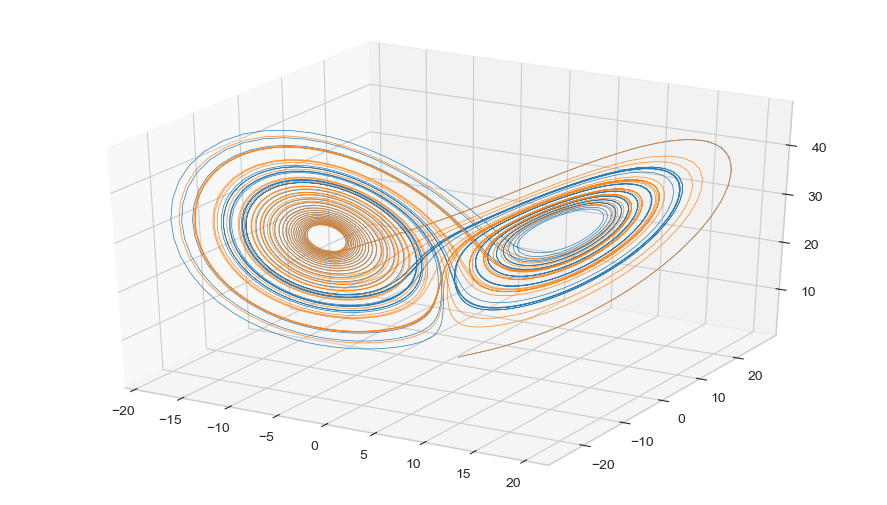

In [147]:
fig = plt.figure()
ax = fig.gca(projection="3d")
ax.plot(*states1.T, linewidth=0.5, alpha=0.95)
ax.plot(*states2.T, linewidth=0.5, alpha=0.95)
plt.show()

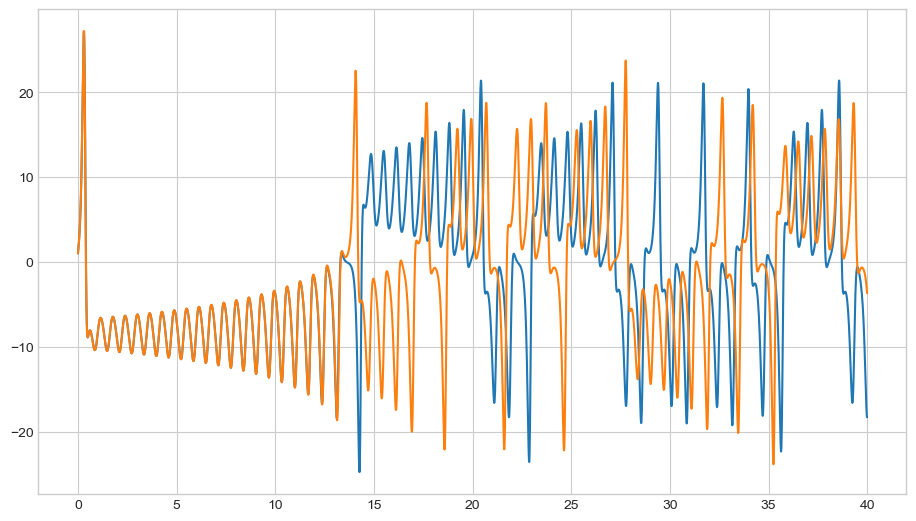

In [148]:
plt.plot(t, states1.T[1])
plt.plot(t, states2.T[1])
plt.show()